<a href="https://colab.research.google.com/github/yujhml/MIRI-Imputation/blob/master/examples/miri_demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIRI: Missing Data Imputation by Reducing Mutual Information

[![arXiv](https://img.shields.io/badge/arXiv-2505.11749-b31b1b.svg)](https://arxiv.org/abs/2505.11749) [![OpenReview](https://img.shields.io/badge/OpenReview-NeurIPS%202025-8c1b13.svg)](https://openreview.net/pdf/b51848c5f9ad724e3a2e5f89c68946ee78f8eff8.pdf) [![Project Page](https://img.shields.io/badge/Project-Page-blue.svg)](https://yujhml.github.io/projects/MIRI/index.html)

This notebook demonstrates MIRI's approach to missing data imputation on a 2D toy dataset. MIRI imputes missing data by reducing mutual information between missing entries and imputed values, conditioned on observed data.

Please select **GPU** runtime types (e.g., **T4 GPU**).

## 1. Setup, Imports, and Data Generation

This section includes all necessary imports and the toy dataset generation function.

In [1]:
# Core imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from time import time
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports (for baseline methods)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def generate_bimodal_data(
    n_samples=3000,
    means=(-2, 2),
    stddev=0.5,
    random_state=0,
):
    """Generate a simple 2D bimodal dataset with diagonal covariance."""
    np.random.seed(random_state)
    cluster1 = np.random.randn(n_samples, 2) * stddev + means[0]
    cluster2 = np.random.randn(n_samples, 2) * stddev + means[1]
    data = np.vstack([cluster1, cluster2])
    np.random.shuffle(data)
    return data


def sample_ref(n, dset="toy", p=0.7, random_state=0):
    """
    Generate toy dataset in-memory and introduce missing values.

    Args:
        n: Number of samples
        dset: Dataset name (kept for API compatibility)
        p: Observation probability (higher = less missing)
        random_state: Seed for reproducibility

    Returns:
        X: Data with missing values (replaced with random noise)
        M: Binary mask (1 = observed, 0 = missing)
        Xstar: Ground truth data
    """
    data = generate_bimodal_data(n_samples=n, means=(-2, 2), stddev=0.5, random_state=random_state)
    Xdata = torch.from_numpy(data).float().to(device)
    X = Xdata[:n, :].detach().clone()
    Xstar = X.detach().clone()

    d = X.shape[1]
    M = torch.distributions.bernoulli.Bernoulli(torch.ones(n, d) * p).sample().to(device)

    X[M == 0] = torch.randn(n, d).to(device)[M == 0]

    return X.cpu(), M.cpu(), Xstar.cpu()

## 2. MIRI Implementation

This section contains the complete implementation of MIRI, including all necessary helper functions and models.

In [3]:
# Utility functions
def totorch(x):
    """Convert numpy array to tensor on the configured device."""
    return torch.tensor(x, dtype=torch.float32, device=device)

In [4]:
# Maximum Mean Discrepancy
def mmd(X, Y, kernel='rbf', sigma=None):
    """
    Maximum Mean Discrepancy - measures distribution distance
    Lower values indicate better match between distributions
    """
    if kernel == 'rbf':
        XX = torch.cdist(X, X)
        XY = torch.cdist(X, Y)
        YY = torch.cdist(Y, Y)

        if sigma is None:
            sigma = np.median(XY.detach().cpu().numpy())

        XX = torch.exp(-XX**2 / (2 * sigma**2)).mean()
        XY = torch.exp(-XY**2 / (2 * sigma**2)).mean()
        YY = torch.exp(-YY**2 / (2 * sigma**2)).mean()

        return XX + YY - 2 * XY
    else:
        raise NotImplementedError

In [5]:
# Mutual Information Neural Estimation (MINE)
class MINE_MLP(nn.Module):
    """Neural network for MINE"""
    def __init__(self, dx, dy):
        super(MINE_MLP, self).__init__()
        self.fc1 = nn.Linear(dx + dy, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def mine_loss(x, y, model):
    """MINE loss function"""
    # Joint distribution
    fxy = model(torch.cat([x, y], dim=1))

    # Marginal distribution (shuffled)
    xshuffle = x[torch.randperm(x.shape[0]), :]
    yshuffle = y[torch.randperm(y.shape[0]), :]
    fxyshuffle = model(torch.cat([xshuffle, yshuffle], dim=1))

    # MINE loss
    loss = -(fxy.mean() - torch.log(torch.exp(fxyshuffle).mean()))
    return loss

def train_test_split(x, y):
    """Split data into train and test sets"""
    idx = torch.randperm(x.shape[0])
    x = x[idx, :]
    y = y[idx, :]

    split_idx = int(0.8 * x.shape[0])
    xtrain = x[:split_idx, :]
    ytrain = y[:split_idx, :]
    xtest = x[split_idx:, :]
    ytest = y[split_idx:, :]

    return xtrain, ytrain, xtest, ytest

def MINE(x0, y0):
    """
    Mutual Information Neural Estimation
    Estimates mutual information between x0 and y0
    """
    x, y, xtest, ytest = train_test_split(x0, y0)

    model = MINE_MLP(x.shape[1], y.shape[1]).to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)
    tensorset = torch.utils.data.TensorDataset(x, y)
    trainloader = torch.utils.data.DataLoader(tensorset, batch_size=100, shuffle=True)

    for epoch in tqdm(range(100), desc="MINE Training"):
        for iter, (xi, yi) in enumerate(trainloader):
            xi = xi.to(device)
            yi = yi.to(device)

            optimizer.zero_grad()
            lossi = mine_loss(xi, yi, model)
            lossi.backward()
            optimizer.step()

    return -mine_loss(xtest.to(device), ytest.to(device), model).item(), model

In [6]:
# MLP Model for MIRI
class MLP(nn.Module):
    """Multi-Layer Perceptron for vector field modeling"""
    def __init__(self, d, hidden_dims=[1001, 1001, 1001], dropout_prob=0.2):
        super(MLP, self).__init__()
        input_dim = 3 * d + 1
        self.d = d
        self.flatten = nn.Flatten()

        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.SiLU())
            prev_dim = hdim

        layers.append(nn.Linear(prev_dim, d))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        m = x[:, -self.d:]
        x = self.flatten(torch.cat([x, t], dim=1))
        return (1 - m) * self.mlp(x)

In [7]:
# Rectified Flow ODE Sampling
@torch.no_grad()
def sample_ode(model, z0=None, N=None, clamp=False):
    """
    Sample from the model by solving ODE

    Args:
        model: Trained neural network
        z0: Initial state [X0, X0, M]
        N: Number of ODE steps
        clamp: Whether to clamp values to [0, 1]
    """
    d = z0.shape[1] // 3
    dt = 1. / N

    for i in range(N):
        t = torch.tensor(i / N, device=device)
        t = t.expand(z0.shape[0], 1)

        pred = model(z0, t)
        z0[:, :d] = z0[:, :d] + pred * dt
        z0[:, d:2*d] = z0[:, d:2*d] + pred * dt

        if clamp:
            z0[:, :d] = torch.clamp(z0[:, :d], 0, 1)

    return z0[:, :d]

In [8]:
# MIRI Imputation
def rectified_impute(X0, M, Xstar, modelclass, max_rounds=10, clamp=False,
                    callback=None, verbose=False, batchsize=100,
                    maxepochs=200, odesteps=200, dsetname="NULL"):
    """
    MIRI's main imputation algorithm using rectified flows

    Args:
        X0: Initial data with missing values
        M: Missing mask (1=observed, 0=missing)
        Xstar: Ground truth (for evaluation)
        modelclass: Neural network class (e.g., MLP)
        max_rounds: Maximum imputation rounds
        clamp: Clamp values to [0, 1]
        batchsize: Training batch size
        maxepochs: Training epochs per round
        odesteps: ODE solver steps

    Returns:
        X0: Imputed data
        mmd_list: MMD scores per round
        mi_list: Mutual information scores per round
        model_list: Trained models per round
    """
    from time import time

    d = X0.shape[1]
    n = X0.shape[0]
    criterion = nn.MSELoss()
    print(f'n: {n}, d: {d}, batchsize: {batchsize}')

    X1 = X0[torch.randperm(X0.shape[0]), :].clone()

    mi_list = []
    mmd_list = []
    model_list = []

    try:
        for round in range(max_rounds):
            model = modelclass(d).to(device)
            model.train()
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            # Compute MMD
            if n > 10000:
                mmd_round = mmd(X0[:10000, :], Xstar[:10000, :])
            else:
                mmd_round = mmd(X0, Xstar)
            print(f'Round: {round+1}, MMD: {mmd_round:.5f}')
            mmd_list.append(mmd_round)

            # Estimate Mutual Information
            print("Estimating mutual information...")
            mi = MINE(X0, M)[0]
            mi_list.append(mi)
            print(f'MI: {mi}')

            print("Training vector field...")

            tensorset = torch.utils.data.TensorDataset(torch.cat([X0, M], dim=1), X1)
            trainloader = torch.utils.data.DataLoader(tensorset, batch_size=batchsize, shuffle=True)

            starttime = time()
            for epoch in tqdm(range(maxepochs), desc=f"Round {round+1}"):
                for iter, (Z0i, X1i) in enumerate(trainloader):
                    X1i = X1i.to(device)
                    X0i = Z0i[:, :d].to(device)
                    Mi = Z0i[:, d:].to(device)

                    # Sample time t from [0, 1]
                    t = torch.rand(X1i.shape[0], 1, device=device)
                    Xti = t * X1i + (1 - t) * X0i

                    # Create conditional inputs
                    Xti1 = Xti.clone()
                    Xti1[Mi == 1] = X0i[Mi == 1]
                    Xti2 = Xti.clone()
                    Xti2[Mi == 1] = X1i[Mi == 1]

                    Zti = torch.cat([Xti1, Xti2, Mi], dim=1)
                    pred = model(Zti, t)
                    y = X1i - X0i
                    loss = criterion(pred[Mi == 0], y[Mi == 0])

                    # Backpropagation
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Imputation phase
            model.eval()
            Z0 = torch.cat([X0, X0, M], dim=1)

            if verbose:
                print("Sampling from the model (solving ODE)...")

            # Impute in batches
            imputebatch = 500
            for i in tqdm(range(0, n, imputebatch), desc="Imputing"):
                Z0i = Z0[i:i+imputebatch, :].clone().to(device)
                Z1i = sample_ode(model, z0=Z0i, N=odesteps, clamp=clamp).to('cpu')
                X0[i:i+imputebatch][M[i:i+imputebatch, :] == 0] = Z1i[M[i:i+imputebatch, :] == 0]

            X1 = X0[torch.randperm(X0.shape[0]), :].clone()

            print(f'Finished round: {round+1} / {max_rounds}, time: {time() - starttime:.2f}s')
            print("")

            model_list.append(model)

    except KeyboardInterrupt:
        print("Interrupted, returning the current imputed data")
        pass

    return X0, mmd_list, mi_list, model_list

In [9]:
# Imputation Wrapper Function
def impute_now(X0, M, Xstar, imputer_name, max_rounds=10, clamp=False,
               callback=None, verbose=False, batchsize=100,
               maxepochs=200, odesteps=200):
    """
    Wrapper function for different imputation methods

    Args:
        X0: Data with missing values
        M: Binary mask (1=observed, 0=missing)
        Xstar: Ground truth data (for evaluation)
        imputer_name: Method name ('miri', 'mice', 'knewimp', etc.)
        max_rounds: Maximum imputation rounds

    Returns:
        X_imputed: Imputed data
        mmd_list: MMD scores
        mi_list: Mutual information scores
    """

    if imputer_name == 'miri':
        print("Using MIRI imputer")
        X0_miri = X0.detach().clone()
        modelclass = MLP
        clamp = False

        X0_imputed, mmd_list, mi_list, model_list = rectified_impute(
            X0_miri, M, Xstar, modelclass, max_rounds, clamp, callback,
            verbose, batchsize, maxepochs, odesteps
        )
        return X0_imputed, mmd_list, mi_list

    elif imputer_name == 'knn':
        X0_knn = X0.detach().clone()
        X0_knn[M == 0] = torch.nan

        if imputer_name == 'knn':
            imputer = KNNImputer(n_neighbors=5)
        else:
            imputer = IterativeImputer(max_iter=1000, random_state=0)

        X0_knn = totorch(imputer.fit_transform(X0_knn.cpu().numpy())).cpu()

        if X0_knn.shape[0] < 15000:
            return X0_knn, torch.Tensor([[mmd(X0_knn, Xstar)]]), torch.Tensor([MINE(X0_knn, M)[0]])
        else:
            return X0_knn, torch.Tensor([[mmd(X0_knn[:15000, :], Xstar[:15000, :])]]), torch.Tensor([MINE(X0_knn, M)[0]])

    elif imputer_name == 'mice':
        X0_knn = X0.detach().clone()
        X0_knn[M == 0] = torch.nan

        imputer = IterativeImputer(max_iter=1000, random_state=0)
        X0_knn = totorch(imputer.fit_transform(X0_knn.cpu().numpy())).cpu()

        if X0_knn.shape[0] < 15000:
            return X0_knn, torch.Tensor([[mmd(X0_knn, Xstar)]]), torch.Tensor([MINE(X0_knn, M)[0]])
        else:
            return X0_knn, torch.Tensor([[mmd(X0_knn[:15000, :], Xstar[:15000, :])]]), torch.Tensor([MINE(X0_knn, M)[0]])

    else:
        raise ValueError(f"Unknown imputer: {imputer_name}")

print("All MIRI functions loaded successfully!")

All MIRI functions loaded successfully!


## 3. Run MIRI on Toy Dataset

Now we'll apply MIRI and baseline methods to the toy dataset.

### 3.1. Configure Experiment and Generate Data

**Parameters:**
- `n`: Number of samples (1000 for demo; paper uses 6000)
- `d`: Dimensionality (2D for visualization)
- `p`: Probability of observing each value (0.7 means ~30% missing rate)
- `methods`: Imputation methods to compare

In [10]:
# Experiment configuration
n = 1000  # Number of samples
d = 2     # Dimensionality (2D for visualization)
p = 0.7   # Observation probability (~30% missing rate)
seed = 1
dset = "toy"

# Set random seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Methods to compare
methods = ['miri', 'mice', 'knn']
print(f"Imputation methods: {methods}")

# Generate dataset
X0, M, Xstar = sample_ref(n, dset, p, random_state=seed)

print(f"\nDataset Information:")
print(f"  Samples (n): {X0.shape[0]}")
print(f"  Dimensions (d): {X0.shape[1]}")
print(f"  Observation probability (p): {p}")
print(f"  Missing rate: {1 - M.mean().item():.2%}")

Imputation methods: ['miri', 'mice', 'knn']

Dataset Information:
  Samples (n): 1000
  Dimensions (d): 2
  Observation probability (p): 0.7
  Missing rate: 30.40%


### 3.2. Run Imputation Methods

Execute each imputation method and keep the results in memory for comparison. This may take a few minutes.

**Methods:**
- **MIRI**: Our method that reduces mutual information
- **MICE**: Multiple Imputation by Chained Equations
- **KNN Imputation**: K-Nearest Neighbors imputation

In [11]:
# Cache to hold in-memory results for downstream analysis
results_cache = {}

for method in methods:
    print(f"Running {method.upper()}...")
    X_tilde, mmd_list, mi_list = impute_now(X0, M, Xstar, method, max_rounds=6, odesteps=500, maxepochs=200)
    results_cache[method] = {
        "X_tilde": X_tilde,
        "mmd_list": mmd_list,
        "mi_list": mi_list,
    }
    print(f"  {method.upper()} complete\n")

Running MIRI...
Using MIRI imputer
n: 1000, d: 2, batchsize: 100
Round: 1, MMD: 0.02155
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


MI: 0.6753005385398865
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Finished round: 1 / 6, time: 8.32s

Round: 2, MMD: 0.00696
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 42.48it/s]


MI: 0.2954190969467163
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Finished round: 2 / 6, time: 8.16s

Round: 3, MMD: 0.00138
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 43.78it/s]


MI: 0.1840265393257141
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Finished round: 3 / 6, time: 8.20s

Round: 4, MMD: 0.00040
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 42.94it/s]


MI: 0.05742451921105385
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Finished round: 4 / 6, time: 8.12s

Round: 5, MMD: 0.00042
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 43.91it/s]


MI: 0.054571837186813354
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Finished round: 5 / 6, time: 7.99s

Round: 6, MMD: 0.00032
Estimating mutual information...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 43.27it/s]


MI: 0.04842756688594818
Training vector field...


Imputing: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Finished round: 6 / 6, time: 8.10s

  MIRI complete

Running MICE...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 36.96it/s]


  MICE complete

Running KNN...


MINE Training: 100%|██████████| 100/100 [00:02<00:00, 42.44it/s]

  KNN complete



### 3.3. Visualize Results

Compare the ground truth, corrupted data, and imputed results using scatter plots and density plots.

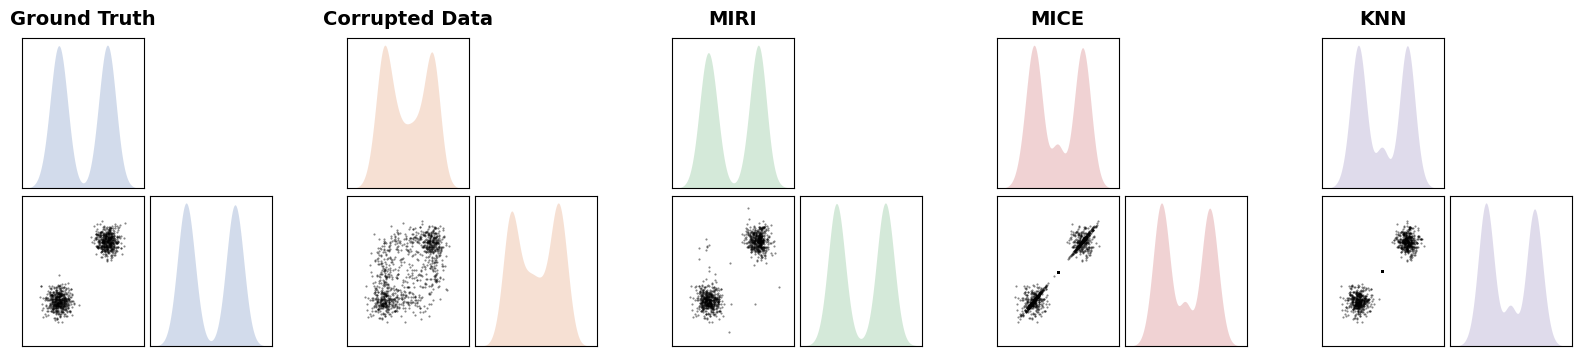

In [12]:
def draw_pairpanel(fig, data_tensor, title, outer_spec, color):
    """Render a pairplot-style panel inside a shared row."""
    data = data_tensor.detach().cpu().numpy()[:, :2]
    sub_spec = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_spec, wspace=0.05, hspace=0.05)
    axes_local = [[None, None], [None, None]]
    for row in range(2):
        for col in range(2):
            axes_local[row][col] = fig.add_subplot(sub_spec[row, col])
            axes_local[row][col].set_xticks([])
            axes_local[row][col].set_yticks([])
            axes_local[row][col].tick_params(bottom=False, left=False)
            if col > row:
                axes_local[row][col].axis("off")

    for diag_idx in range(2):
        sns.kdeplot(
            x=data[:, diag_idx],
            ax=axes_local[diag_idx][diag_idx],
            fill=True,
            color=color,
            linewidth=0,
        )
        axes_local[diag_idx][diag_idx].set_xlim(-5, 5)

    axes_local[1][0].scatter(data[:, 0], data[:, 1], s=0.25, color="black", alpha=0.5)
    axes_local[1][0].set_xlim(-5, 5)
    axes_local[1][0].set_ylim(-5, 5)
    axes_local[0][0].set_title(title, fontsize=14, fontweight="bold", pad=10)


datasets = [
    ("Ground Truth", Xstar),
    ("Corrupted Data", X0),
]

for method in methods:
    cached = results_cache.get(method)
    if cached is None:
        continue
    datasets.append((f"{method.upper()}", cached["X_tilde"]))

n_panels = len(datasets)
fig = plt.figure(figsize=(4 * n_panels, 4))
outer = gridspec.GridSpec(1, n_panels, wspace=0.3, figure=fig)
palette = sns.color_palette("deep", n_panels)

for idx, (title, tensor) in enumerate(datasets):
    draw_pairpanel(fig, tensor, title, outer[idx], palette[idx])

plt.show()

### 3.4. Quantitative Evaluation

Analyze the quality of imputation using MMD (Maximum Mean Discrepancy) and MI (Mutual Information) metrics.

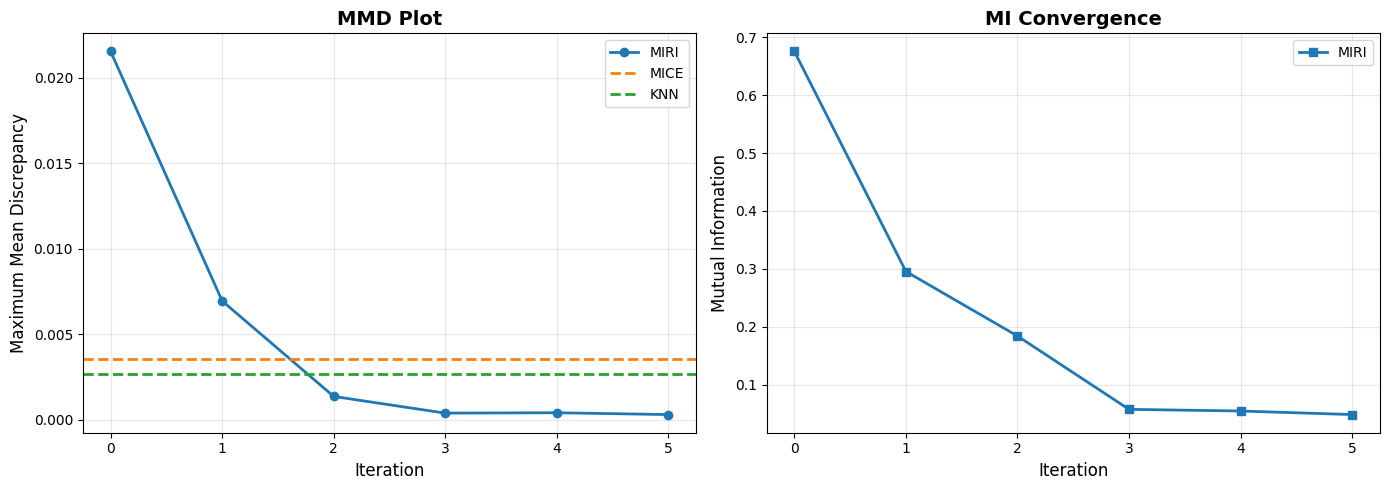

In [13]:
# Collect metrics for all methods
results_summary = []
method_metrics = {}


def _to_float_sequence(values):
    if values is None:
        return []
    if isinstance(values, torch.Tensor):
        return [float(v) for v in values.flatten().tolist()]
    floats = []
    for val in values:
        if torch.is_tensor(val):
            floats.append(float(val.detach().cpu().item()))
        else:
            floats.append(float(val))
    return floats


for method in methods:
    cached = results_cache.get(method)
    if cached is None:
        continue

    mmd_vals = _to_float_sequence(cached["mmd_list"])
    mi_vals = _to_float_sequence(cached["mi_list"])
    method_metrics[method] = {
        "mmd": mmd_vals,
        "mi": mi_vals,
    }

    final_mmd = mmd_vals[-1] if mmd_vals else None
    final_mi = mi_vals[-1] if mi_vals else None
    mmd_improvement = mmd_vals[0] - final_mmd if final_mmd is not None and mmd_vals else None

    results_summary.append({
        "Method": method.upper(),
        "Final MMD": final_mmd,
        "Final MI": final_mi,
        "MMD Improvement": mmd_improvement,
    })

# Plot MMD and MI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

method_colors = {
    "miri": "#1f77b4",
    "mice": "#ff7f0e",
    "knn": "#2ca02c",
}

for method, metrics in method_metrics.items():
    mmd_list = metrics["mmd"]
    mi_list = metrics["mi"]
    color = method_colors.get(method)

    if mmd_list:
        if method == "miri":
            ax1.plot(range(len(mmd_list)), mmd_list, marker="o", label=method.upper(), linewidth=2, color=color)
        else:
            ax1.axhline(mmd_list[-1], linestyle="--", label=method.upper(), linewidth=2, color=color)

    if method == "miri" and mi_list:
        ax2.plot(range(len(mi_list)), mi_list, marker="s", label=method.upper(), linewidth=2, color=color)

ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Maximum Mean Discrepancy", fontsize=12)
ax1.set_title("MMD Plot", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Mutual Information", fontsize=12)
ax2.set_title("MI Convergence", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5. Conclusion

**Key Observations:**

1. **Visual Quality**: MIRI should preserve the underlying structure of the data better than baseline methods
2. **MMD Score**: Lower MMD indicates better match to the true data distribution
3. **MI Reduction**: MIRI specifically optimizes for reducing mutual information, which helps avoid overfitting to missing patterns

**Next Steps:**
- Try `demo_UCI.ipynb` for real-world dataset experiments
- Try `demo_imgs.ipynb` for image imputation examples
- Experiment with different missing rates and dimensionalities

For more information, visit the [project page](https://yujhml.github.io/projects/MIRI/index.html) or read the [paper](https://arxiv.org/abs/2505.11749).